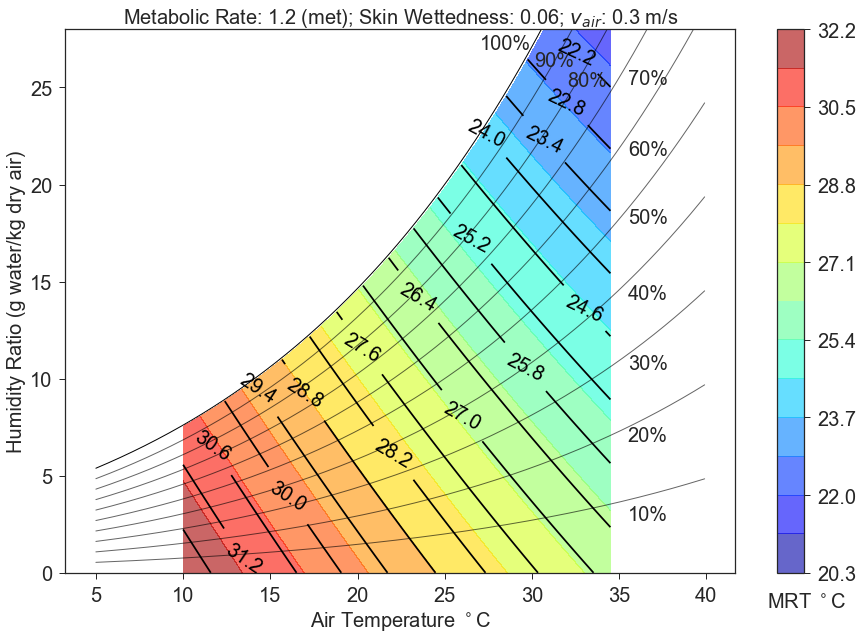

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import seaborn #Seaborn is a a stats plotting library that sits on matplotlib
%matplotlib inline

mpl.rcParams['font.family'] = 'Arial'
textsize=18

seaborn.set_style("white")
seaborn.set_style("ticks")


#air temperature range over which calculations are performed [oC]
temp_air_init = np.arange(10, 35, .5)

#%RH range over which calculations are performed [%RH/100]
RH_psy_init = np.arange(0,100,1)/100

#metabolic rate for a person in [W/m2]. default value is 69.8 W/m2, equivalent to 1.2 met (the other unit for metabolic rate)
MR_orig = 1.2

#do not change, changes MR_orig inputs in 'met' to W/m2
MR= MR_orig*58.2

#skin wettedness parameter, [unitless]
#0.06 for dry skin, accounts for diffusion through skin
#0.8 is the practical upper bound for very sweaty skin
w=0.06

#air speed in [m/s]
v=0.3

#the air temperature minus the mean radiant temperature (MRT) [K]
#this is specified to calculate a wind speed for thermal comfort
#values > 0 are for an air temperature greater than the MRT 
#values < 0 are for an air temperature lower than the MRT
dep = 0.0000

#emissivity of human skin [unitless]
#values in the literature vary between 0.95 to 0.98
E=0.95


#Stephan Botlztmans constant
o = 0.00000005670367

#empirical ratio for a seated person
Ar_Ad = 0.7

#empirical ratio for calculating the evaporative "heat transfer" coefficient
LR = 16.5

#define psychrometric temp bounds for drawing %RH lines
temperature = np.arange(5, 40, 0.1)

#redefine temp and %RH arrays
temp_air = np.tile(np.array(temp_air_init),(len(RH_psy_init),1)).transpose()
RH_psy = np.tile(np.array(RH_psy_init),(len(temp_air_init),1))

#2D relative humidity array dimension constant 
dim1 = len(RH_psy)

#2D air temperature array dimension constant 
dim2 = len(temp_air)

#clausius-clapyron constants
a=17.08
b=234.18
saturation = 1000*0.62198*np.exp(77.345+0.0057*(temperature+273.15)-7235/(temperature+273.15))/(101325*np.power((temperature+273.15),8.2)-np.exp(77.345+0.0057*(temperature+273.15)-7235/(temperature+273.15)))


#for an arbitrary fixed comfort zone box calculation
#Mapped everything from relative humidity to absolute humidity
#BL = Bottom Left ...
BL = 0.3*1000*0.62198*np.exp(77.345+0.0057*(21+273.15)-7235/(21+273.15))/(101325*np.power((21+273.15),8.2)-np.exp(77.345+0.0057*(21+273.15)-7235/(21+273.15)))
TL = 0.6*1000*0.62198*np.exp(77.345+0.0057*(21+273.15)-7235/(21+273.15))/(101325*np.power((21+273.15),8.2)-np.exp(77.345+0.0057*(21+273.15)-7235/(21+273.15)))
BR = 0.3*1000*0.62198*np.exp(77.345+0.0057*(27+273.15)-7235/(27+273.15))/(101325*np.power((27+273.15),8.2)-np.exp(77.345+0.0057*(27+273.15)-7235/(27+273.15)))
TR = 0.6*1000*0.62198*np.exp(77.345+0.0057*(27+273.15)-7235/(27+273.15))/(101325*np.power((27+273.15),8.2)-np.exp(77.345+0.0057*(27+273.15)-7235/(27+273.15)))
comfort = np.arange(21, 27, 0.1)



#ARRAY DECLARATIONS AND CALCULATIONS

#skin temp calculation
temp_skin = temp_air*.3812+22.406

#vapor pressure of water on skin's surface
P_sat_skin_psy = np.power(2.718,(77.3450+0.0057*(temp_skin+273.15)-7235/(temp_skin+273.15)))/(np.power((temp_skin+273.15),8.2))/1000

#mapping %RH matrix to specific humidity for plotting
psy_sat = np.zeros((dim2, dim1))
psy_sat = 1000*0.62198*np.exp(77.345+0.0057*(temp_air+273.15)-7235/(temp_air+273.15))/(101325*np.power((temp_air+273.15),8.2)-np.exp(77.345+0.0057*(temp_air+273.15)-7235/(temp_air+273.15)))*RH_psy

#vapor pressure of water in air
P_sat_air_psy = np.zeros((dim2, dim1))
P_sat_air_psy = np.power(2.718,(77.3450+0.0057*(temp_air+273.15)-7235/(temp_air+273.15)))/(np.power((temp_air+273.15),8.2))/1000*RH_psy

#free convection heat transfer coefficient for seated person
h_c_free_psy = 0.78*np.power(np.absolute(temp_skin-temp_air),0.56)

#free convection around the human body
Q_conv_free_psy = np.zeros((dim2, dim1))
Q_conv_free_psy = h_c_free_psy*(temp_skin-temp_air)

#free convection evaporative heat transfer coefficient
h_e_free_psy = h_c_free_psy*LR

#associated evaporative "heat transfer" about the human body (free convection)
Q_evap_free_psy = np.zeros((dim2, dim1))
Q_evap_free_psy = h_e_free_psy*w*(P_sat_skin_psy-P_sat_air_psy)

#solved mean radiant temperature required for thermal comfort taking free convection into account
T_MRT_psy = np.zeros((dim2, dim1))
T_MRT_psy = np.power(np.power((temp_skin+273.15),4)-((MR-Q_evap_free_psy-Q_conv_free_psy)/E/o/Ar_Ad),0.25)-273.15

#forced convection heat transfer coefficient calculation
h_c_forced_psy = 10.1*np.power(v,0.61)

#forced convection around the human body
Q_conv_forced_psy = np.zeros((dim2, dim1))
Q_conv_forced_psy = h_c_forced_psy*(temp_skin-temp_air)    

#forced convection evaporative heat transfer coefficient
h_e_forced_psy = h_c_forced_psy*LR

#associated evaporative "heat transfer" about the human body (free convection)
Q_evap_forced_psy = np.zeros((dim2, dim1))
Q_evap_forced_psy = h_e_forced_psy*w*(P_sat_skin_psy-P_sat_air_psy)
#solved mean radiant temperature required for thermal comfort taking forced convection into account
T_MRT_forced_psy = np.zeros((dim2, dim1))
T_MRT_forced_psy = np.power(np.power((temp_skin+273.15),4)-((MR-Q_evap_forced_psy-Q_conv_forced_psy)/E/o/Ar_Ad),0.25)-273.15

#calculate mean radiant temperature when "dep" parameter is specified to solve for required air speed
temp_MRT = temp_air - dep

#linearizing radiant heat transfer coefficient 
h_r_forced_v = 4*E*o*Ar_Ad*np.power((273.15+(temp_skin+temp_MRT)/2),3)

#linearized radiant heat transfer
Q_rad_forced_v = np.zeros((dim2, dim1)) 
Q_rad_forced_v = h_r_forced_v*E*(temp_skin-temp_MRT)

#required air speed for thermal comfort using the 'dep' parameter to fix the mean radiant temperature
v_forced_v = np.zeros((dim2, dim1))
v_forced_v = np.power(((MR-Q_rad_forced_v)/(10.1*(LR*w*(P_sat_skin_psy-P_sat_air_psy)+(temp_skin-temp_air)))),(1/0.61))


plt.figure(figsize=(15,10))
X,Y = np.meshgrid(RH_psy_init, temp_air_init)

#set text size
textsize = 20

#set transparency
alph = 0.6
plt.plot(temperature, saturation, 'k-', linewidth = 1, alpha = 1)
plt.plot(temperature, saturation*.9, 'k-', linewidth = 1 , alpha = alph)
plt.plot(temperature, saturation*.8, 'k-', linewidth = 1, alpha = alph)
plt.plot(temperature, saturation*.7, 'k-', linewidth = 1,alpha = alph)
plt.plot(temperature, saturation*.6, 'k-', linewidth = 1,alpha = alph)
plt.plot(temperature, saturation*.5, 'k-', linewidth = 1,alpha = alph)
plt.plot(temperature, saturation*.4, 'k-', linewidth = 1,alpha = alph)
plt.plot(temperature, saturation*.3, 'k-', linewidth = 1,alpha = alph)
plt.plot(temperature, saturation*.2, 'k-', linewidth = 1,alpha = alph)
plt.plot(temperature, saturation*.1, 'k-', linewidth = 1,alpha = alph)

#select desired plot using input-based logic 
if dep != 0:
    levels_contour = np.linspace(0.1, 2, 150)
    CS3=plt.contourf(Y, psy_sat, v_forced_v, cmap = 'jet', levels=levels_contour,interpolation='sinc', fontsize = 20, dpi = 1200, alpha = 0.6)
    cbar = plt.colorbar(CS3, orientation='vertical', format="%.1f")
    plt.text(44,-1.45,"m/s", size=textsize)
    plt.title("Metabolic Rate: "+str(MR_orig)+ " (met); Skin Wettedness: "+str(w)+"; $T_{air} = T_{MRT}$", size = textsize)


elif v < 0.2:
    levels_contour = np.linspace(np.amin(T_MRT_psy), np.amax(T_MRT_psy), 15)
    CS3=plt.contourf(Y, psy_sat, T_MRT_psy, cmap = 'jet', levels=levels_contour,interpolation='sinc', fontsize = 20, dpi = 1200, alpha = 0.6)
    CS = plt.contour(Y, psy_sat, T_MRT_psy, 15, colors='k', alpha = 1)
    plt.clabel(CS, inline=3, fmt='%1.1f', fontsize=textsize)
    cbar = plt.colorbar(CS3, orientation='vertical', format="%.1f")
    plt.text(43.5,-1.75,"MRT $^\circ$C", size=textsize)
    plt.title("Metabolic Rate: "+str(MR_orig)+ " (met); Skin Wettedness: "+str(w)+"; Free Convection", size = textsize)

else:
    #Forced Convection Plots. 
    levels_contour = np.linspace(np.amin(T_MRT_forced_psy), np.amax(T_MRT_forced_psy), 15)
    CS3=plt.contourf(Y, psy_sat, T_MRT_forced_psy, cmap = 'jet', levels=levels_contour,interpolation='sinc', fontsize = 20, dpi = 1200, alpha = 0.6)
    CS = plt.contour(Y, psy_sat, T_MRT_forced_psy, 20, colors='k', alpha = 1)
    plt.clabel(CS, inline=3, fmt='%1.1f', fontsize=textsize)
    cbar = plt.colorbar(CS3, orientation='vertical', format="%.1f")
    plt.text(43.5,-1.75,"MRT $^\circ$C", size=textsize)
    plt.title("Metabolic Rate: "+str(MR_orig)+ " (met); Skin Wettedness: "+str(w)+"; $v_{air}$: "+str(v)+" m/s", size = textsize)

plt.text(35.5, 2.7, '10%',size=textsize)
plt.text(35.5, 6.8, '20%',size=textsize)
plt.text(35.5, 10.5, '30%',size=textsize)
plt.text(35.5, 14.1, '40%',size=textsize)
plt.text(35.5, 18, '50%',size=textsize)
plt.text(35.5, 21.5, '60%',size=textsize)
plt.text(35.5, 25.2, '70%',size=textsize)
plt.text(32, 25.1, '80%',size=textsize)
plt.text(30.1, 26.1, '90%',size=textsize)
plt.text(27, 27, '100%',size=textsize)


plt.xlabel("Air Temperature $^\circ$C", size=textsize)
plt.ylabel("Humidity Ratio (g water/kg dry air)",size=textsize)

axes=plt.gca()
axes.set_ylim([0,28])


plt.tick_params(axis='both', labelsize=textsize)
cbar.ax.tick_params(labelsize=textsize) 

plt.savefig("w"+str((round(w*100)))+"MR"+str(round(MR)) + "v10_" + str(round(v*10))+"dep1000_"+str(dep*1000)+".pdf",format='pdf')

